# 클러스터링 방법
- K-means
- DBSCAN
- Spectral Clustering
- Affinity Propagation
- Hierarchical Clustering


- `make_blobs`
    - [n_centers, n_features]
    - `n_features`: 독립변수 수
    - `centers`:  클러스터 갯수
    - `cluster_std`:  클러스터의 표준 편차
    - return
        - X: [n_samples, n_features]
        - y: [n_samples]

sklean tutorial

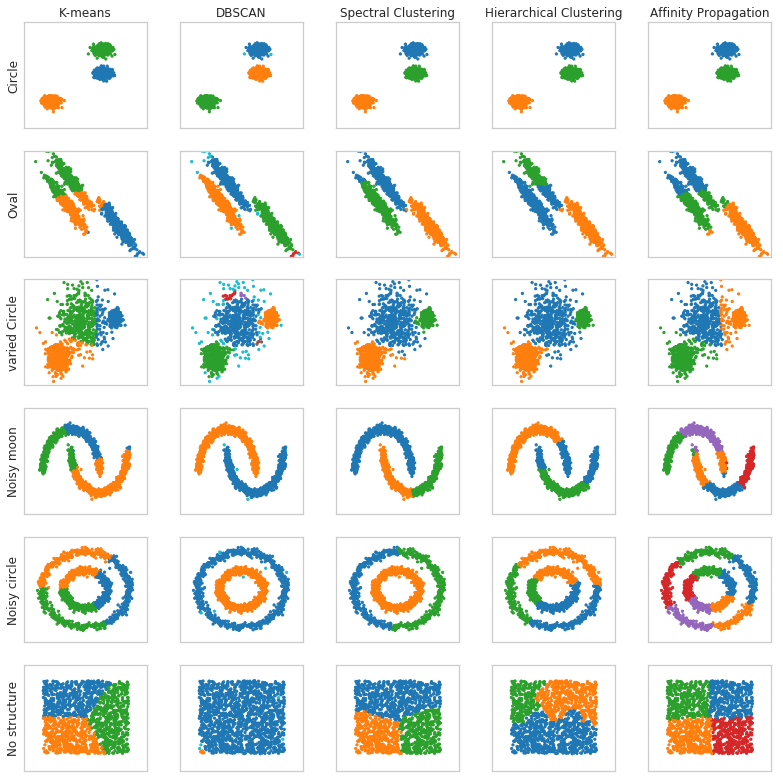

In [37]:
from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.cluster import KMeans, DBSCAN, \
SpectralClustering, AffinityPropagation, hierarchical, \
MiniBatchKMeans, AgglomerativeClustering
from sklearn.utils.testing import ignore_warnings
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
n_samples = 1500

blobs = make_blobs(n_samples=n_samples, random_state=8)
X, y = make_blobs(n_samples=n_samples, random_state=170)

# target data
anisotropic = (np.dot(X, [[0.6, -0.6], [-0.4, 0.8]]), y)
varied = make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5],
                   random_state=170)
noisy_circles = make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = make_moons(n_samples=n_samples, noise=.05)
no_structure = np.random.rand(n_samples, 2), None

datasets = {
    "Circle": blobs,
    "Oval": anisotropic,
    "varied Circle": varied,
    "Noisy moon": noisy_moons,
    "Noisy circle": noisy_circles,
    "No structure": no_structure
}

# algo
two_means = MiniBatchKMeans(n_clusters=3)
dbscan = DBSCAN(eps=0.15)
spectral = SpectralClustering(n_clusters=3, affinity="nearest_neighbors")
ward = AgglomerativeClustering(n_clusters=3)
affinity_propagation = AffinityPropagation(damping=0.9, preference=-200)

clustering_algorithms = (
    ('K-means', two_means),
    ('DBSCAN', dbscan),
    ('Spectral Clustering', spectral),
    ('Hierarchical Clustering', ward),
    ('Affinity Propagation', affinity_propagation),
)

# plotting
plt.figure(figsize=(11, 11))
plot_num = 1
for i, (data_name, (X, y)) in enumerate(datasets.items()):
    X = StandardScaler().fit_transform(X)
    for j, (name, algo) in enumerate(clustering_algorithms):
        with ignore_warnings(category=UserWarning):
            algo.fit(X)
        if hasattr(algo, 'labels_'):
            y_pred = algo.labels_.astype(np.int)
        else:
            y_pred = algo.predict(X)
        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        
        if i == 0:
            plt.title(name)
        if j == 0:
            plt.ylabel(data_name)
        colors = plt.cm.tab10(np.arange(20, dtype=int))
        plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred])
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

plt.tight_layout()
plt.show()

# 성능 평가
- Adjusted Rand Index
- Adjusted Mutual Information
- Silhouette Coefficient

# Incidence Matrix
- GroundTruth vs Result
- Groudtruth: 정답

In [4]:
# 정답
groundtruth = np.array([
    [1, 1, 1, 0, 0],
    [1, 1, 1, 0, 0],
    [1, 1, 1, 0, 0],
    [0, 0, 0, 1, 1],
    [0, 0, 0, 1, 1],
])
groundtruth

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 1, 1]])

In [5]:
# 클러스터링 결과
clustering = np.array([
    [1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0],
    [0, 0, 1, 1, 1],
    [0, 0, 1, 1, 1],
    [0, 0, 1, 1, 1],
])
clustering

array([[1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1]])

In [7]:
incidence = 1 * (groundtruth == clustering)
incidence

array([[1, 1, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [0, 0, 1, 0, 0],
       [1, 1, 0, 1, 1],
       [1, 1, 0, 1, 1]])

# Rand Index
- 기댓값 높음
    - 대각 성분 정답처리
    - symetric이므로 점수 추가
- 무작위 클러스터링도 높은 점수

In [13]:
np.sum(incidence) / np.prod(incidence.shape)

0.68

# Adjusted Rand Index
- Rand Index 기댓값을 원래 값에서 차감

$$
ARI = \frac{RandIndex - Expectation}{Max - Expectation}
$$

In [43]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import StandardScaler

X, y_true = anisotropic
X = StandardScaler().fit_transform(X)
for name, algo in clustering_algorithms:
    with ignore_warnings(category=UserWarning):
        algo.fit(X)
    if hasattr(algo, 'labels_'):
        y_pred = algo.labels_.astype(np.int)
    else:
        y_pred = algo.predict(X)
    print("{:25s}: ARI={:5.3f}".\
         format(name, adjusted_rand_score(y_true, y_pred)))

K-means                  : ARI=0.607
DBSCAN                   : ARI=0.975
Spectral Clustering      : ARI=0.959
Hierarchical Clustering  : ARI=0.685
Affinity Propagation     : ARI=0.617


# Adjusted Mutual Information
- mutual information
    - 확률변수
        - T: 정답의 이산확률변수
        - C: 클러스터링 결과의 이산확률변수
    - 두 확률변수간 상호 의존성 측정
    - 클러스터링 결과를 이산확률변수라고 가정
    - 최소값: 0
    - 의존성 강할수록 증가
    - 클러스터 갯수 많아질수록 증가

In [44]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler

X, y_true = anisotropic
X = StandardScaler().fit_transform(X)
for name, algo in clustering_algorithms:
    with ignore_warnings(category=UserWarning):
        algo.fit(X)
    if hasattr(algo, 'labels_'):
        y_pred = algo.labels_.astype(np.int)
    else:
        y_pred = algo.predict(X)
    print("{:25s}: ARI={:5.3f}".\
         format(name, adjusted_mutual_info_score(y_true, y_pred)))

K-means                  : ARI=0.615
DBSCAN                   : ARI=0.924
Spectral Clustering      : ARI=0.944
Hierarchical Clustering  : ARI=0.731
Affinity Propagation     : ARI=0.621


# 실루엣 계수: groundtruth 없는 경우
- 모든 데이터 쌍(i, j)에 대해 distance & dissimilarity 구한다
    - $a_i$: i와 **같은 클러스터**에 속한 원소들의 평균거리
    - $b_j$: i와 **다른 클러스터** 중 가장 가까운 클러스터까지의 평균 거리
- 실루엣 계수
    - b는 크고, a는 작은 게 좋음
    - 음수의 경우 b < a


$$
s = \dfrac{b-a}{max(a,b)}
$$


KMeans & blobs

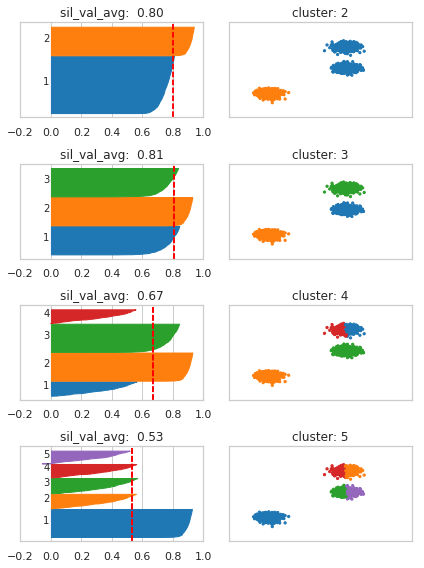

In [36]:
from sklearn.metrics import silhouette_samples

# sample 1500개 점
sc = StandardScaler()
X = sc.fit_transform(blobs[0]) 
colors = plt.cm.tab10(np.arange(20, dtype=int))

plt.figure(figsize=(6, 8))
for i in range(4):
    n_clusters = i + 2
    
    mod = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = mod.fit_predict(X)
    
    sample_sil_val = silhouette_samples(X, cluster_labels)
    sil_avg = sample_sil_val.mean()
    
    plt.subplot(4,2,2*i+1)
    y_lower = 10
    for j in range(n_clusters):
        jth_cluster_sil_val = sample_sil_val[cluster_labels == j]
        jth_cluster_sil_val.sort()
        size_cluster_j = jth_cluster_sil_val.shape[0]
        y_upper = y_lower + size_cluster_j
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, jth_cluster_sil_val,
                        facecolor=colors[j], edgecolor=colors[j])
        plt.text(-0.05, y_lower+0.5*size_cluster_j, str(j+1))
        plt.axvline(x=sil_avg, color='red', linestyle='--')
        plt.xticks([-.2, 0, .2, .4, .6, .8, 1])
        plt.yticks([])
        plt.title("sil_val_avg: {:5.2f}".format(sil_avg))
        y_lower = y_upper + 10
    
    plt.subplot(4,2,2*i+2)
    plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[cluster_labels])
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.title("cluster: {}".format(i+2))

plt.tight_layout()
plt.show()

DBSCAN & anisotropic
- eps 커지면 한 개 클러스터 범위가 넓어짐

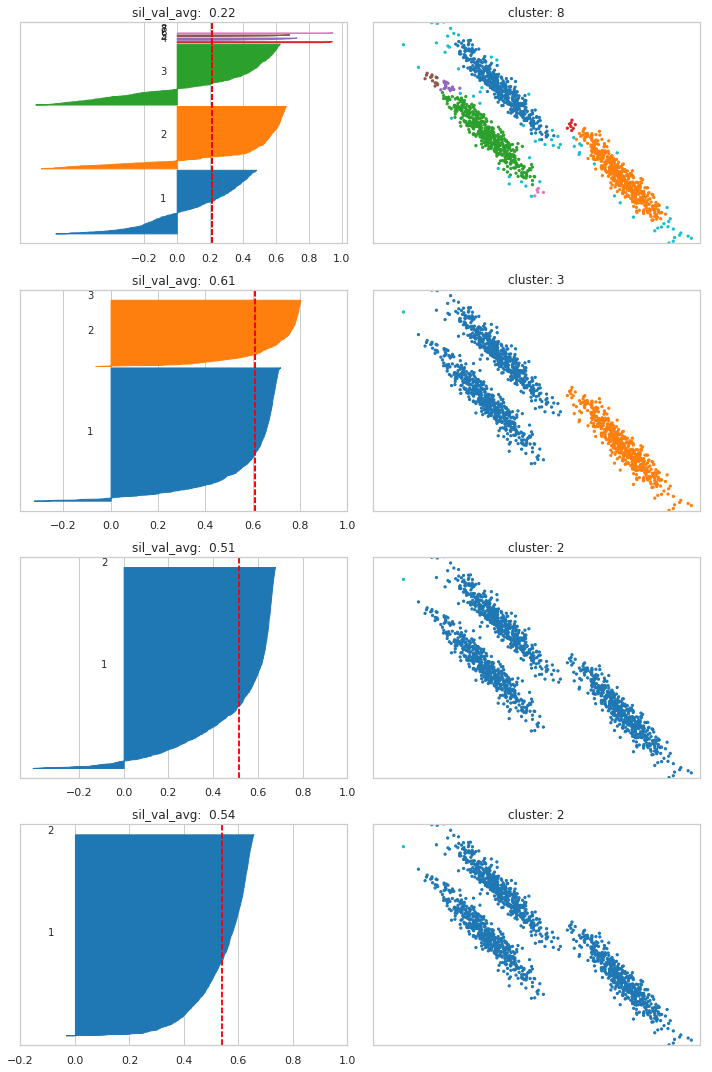

In [60]:
from sklearn.metrics import silhouette_samples

# sample 1500개 점
sc = StandardScaler()
X = sc.fit_transform(anisotropic[0]) 
colors = plt.cm.tab10(np.arange(20, dtype=int))

plt.figure(figsize=(10, 15))
for i in range(4):
    eps = 0.1 + i/10
    
    mod = DBSCAN(eps=eps)
    cluster_labels = mod.fit_predict(X)
    n_clusters = len(np.unique(cluster_labels))
    sample_sil_val = silhouette_samples(X, cluster_labels)
    sil_avg = sample_sil_val.mean()
    
    plt.subplot(4,2,2*i+1)
    y_lower = 10
    for j in range(n_clusters):
        jth_cluster_sil_val = sample_sil_val[cluster_labels == j]
        jth_cluster_sil_val.sort()
        size_cluster_j = jth_cluster_sil_val.shape[0]
        y_upper = y_lower + size_cluster_j
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, jth_cluster_sil_val,
                        facecolor=colors[j], edgecolor=colors[j])
        plt.text(-0.1, y_lower+0.5*size_cluster_j, str(j+1))
        plt.axvline(x=sil_avg, color='red', linestyle='--')
        plt.xticks([-.2, 0, .2, .4, .6, .8, 1])
        plt.yticks([])
        plt.title("sil_val_avg: {:5.2f}".format(sil_avg))
        y_lower = y_upper + 10
    
    plt.subplot(4,2,2*i+2)
    plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[cluster_labels])
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.title("cluster: {}".format(n_clusters))

plt.tight_layout()
plt.show()